In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Load the dataset (replace with your actual file path)
#df = pd.read_csv('data/2024-06-01_2024-09-01/aggregated/percent_return.csv')
#df = pd.read_csv('data/2024-08-20_2024-08-28/aggregated/percent_return.csv')
#df = pd.read_csv('data/2023-09-01_2024-09-01/aggregated/percent_return.csv') # 1 year's worth of data
df = pd.read_csv('data/2020-09-01_2024-09-01/aggregated/percent_return.csv')

clustered_df = pd.read_csv('data/Cluster_data/3Clusters(2020-09-01_2024-09-01).csv')

# Extract stock names
stock_names = clustered_df.columns[1:]  # Assuming the first column is the date

# Get companies in Cluster 1, dropping any NaN values
cluster_2_companies = clustered_df['Cluster 2'].dropna().tolist()

# Filter the dataset to include only Cluster 1 companies
df_cluster_2 = df[['date'] + [col for col in df.columns if col in cluster_2_companies]]
df_cluster_2.head(11)
# Print the filtered DataFrame
counter=0
for col in df_cluster_2.columns:
    print(col)
    counter+=1
    print(counter)
df_cluster_2.to_csv("data\cluster_2")
#print(df) #every 5th row is a friday
#print(df) #every 5th row is a friday

date
1
AAPL
2
AMAT
3
AME
4
AON
5
APA
6
APH
7
BALL
8
BRO
9
BWA
10
CARR
11
CBOE
12
CDW
13
CF
14
CHD
15
CI
16
COR
17
CTVA
18
DE
19
DG
20
DHI
21
DHR
22
DPZ
23
EA
24
EFX
25
EL
26
ELV
27
EQT
28
EXPD
29
FCX
30
FDS
31
FOX
32
FOXA
33
FTV
34
GL
35
GPN
36
HAL
37
HCA
38
HES
39
HUM
40
INTU
41
J
42
JBHT
43
JKHY
44
KKR
45
KLAC
46
L
47
LEN
48
LH
49
LLY
50
LUV
51
LW
52
MA
53
MAR
54
MCHP
55
MCK
56
MCO
57
MKTX
58
MLM
59
MOS
60
MSCI
61
MSFT
62
NDSN
63
NKE
64
NUE
65
NWS
66
NWSA
67
NXPI
68
PARA
69
PGR
70
PHM
71
POOL
72
RMD
73
ROL
74
ROP
75
ROST
76
SBAC
77
SCHW
78
SHW
79
SLB
80
SPGI
81
STE
82
STLD
83
SYK
84
TFX
85
TPL
86
UHS
87
UNH
88
V
89
VMC
90
VRSK
91
WAB
92
ZBH
93
ZTS
94


In [39]:
df.shape

(1006, 492)

In [40]:
# Identify companies in Cluster 1 not found in df
missing_companies = [company for company in cluster_2_companies if company not in df.columns]
print(f"Companies in Cluster 1 not found in df: {missing_companies}")
print(f"Number of companies in Cluster 1: {len(cluster_2_companies)}")
print(f"Number of matched companies: {len(cluster_2_companies) - len(missing_companies)}")


Companies in Cluster 1 not found in df: []
Number of companies in Cluster 1: 93
Number of matched companies: 93


In [41]:
# Prepare the data for Monday to Thursday (features) and Friday (target)
X = []
y = []

# Iterate over the dataset in chunks of 5 rows (representing one week)
for i in range(0, len(df_cluster_2), 5):
    if i + 4 >= len(df_cluster_2):  # Prevent going out of bounds
        break
    # Monday to Thursday data (features)
    X.extend(df_cluster_2.iloc[i:i+4, 1:].T.values.tolist()) # rows are companies
    #X += df.iloc[i:i+4, 1:].T.values
    # Friday data (target)
    y.extend(df_cluster_2.iloc[i+4, 1:].T.values.tolist())  # Friday returns as target

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np

# Define the parameter distributions
param_dist = {
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2],
    'gamma': [0, 2, 4, 6, 8, 10],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_delta_step': [0, 2, 4, 6, 8, 10],
    'n_estimators': [100, 150, 200, 250, 300],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'alpha': [0, 1, 2, 5, 10],  # L1 regularization
    'lambda': [1, 2, 4, 6, 8, 10],  # Adjusted L2 regularization
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings to sample
    scoring='r2',  # Optimize for R^2 score
    cv=TimeSeriesSplit(n_splits=5),  # 5-fold cross-validation, with time series(stock data)
    random_state=42,  # For reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the random search
random_search.fit(X_train, y_train)

# Output best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)

# Retrieve the best model
best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

# Evaluate the model on the test set
predictions = best_model.predict(X_test)

Best Parameters: {'subsample': 0.7, 'n_estimators': 150, 'min_child_weight': 8, 'max_depth': 4, 'max_delta_step': 8, 'learning_rate': 0.03, 'lambda': 8, 'gamma': 8, 'alpha': 1}
Best R^2 Score: 0.40434038442343667


In [43]:
from sklearn.dummy import DummyRegressor

# Baseline model that predicts the mean y for all feature values
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)

In [44]:
# Calculate R^2 scores
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='r2')
print("Cross-Validation Scores (Training Data):", cv_scores)
print("Mean CV R^2 Score:", np.mean(cv_scores))

# Evaluate on test set
test_r2 = r2_score(y_test, best_model.predict(X_test))
print("Test R^2 Score:", test_r2)

baseline_r2 = r2_score(y_test, baseline_predictions) # should be 0, since it predicts the mean
print(f"Baseline R^2 Score: {baseline_r2}")


Cross-Validation Scores (Training Data): [0.42157087 0.38892766 0.4029194  0.41594327 0.39234071]
Mean CV R^2 Score: 0.40434038442343667
Test R^2 Score: 0.4025757789227854
Baseline R^2 Score: -8.51727663624402e-05


In [45]:
### Model evaluation
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse}")

# Calculate RMSE for baseline
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Baseline RMSE:", baseline_rmse)
print("Model Improvement:", baseline_rmse - rmse)

Model RMSE: 1.754114161022904
Baseline RMSE: 2.2695248160370163
Model Improvement: 0.5154106550141122


In [46]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse:.2f}")

# Calculate Baseline RMSE
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Model Improvement: {baseline_rmse - rmse:.2f}")

# Daily change standard deviation
daily_changes = np.diff(predictions).std()
print(f"Daily Change Std Dev: {daily_changes}")

# Residuals (errors for each prediction)
residuals = y_test - predictions
print(f"Residuals Std. Dev: {np.std(residuals)}")

Model RMSE: 1.75
Baseline RMSE: 2.27
Model Improvement: 0.52
Daily Change Std Dev: 2.053410053253174
Residuals Std. Dev: 1.7540626220242461


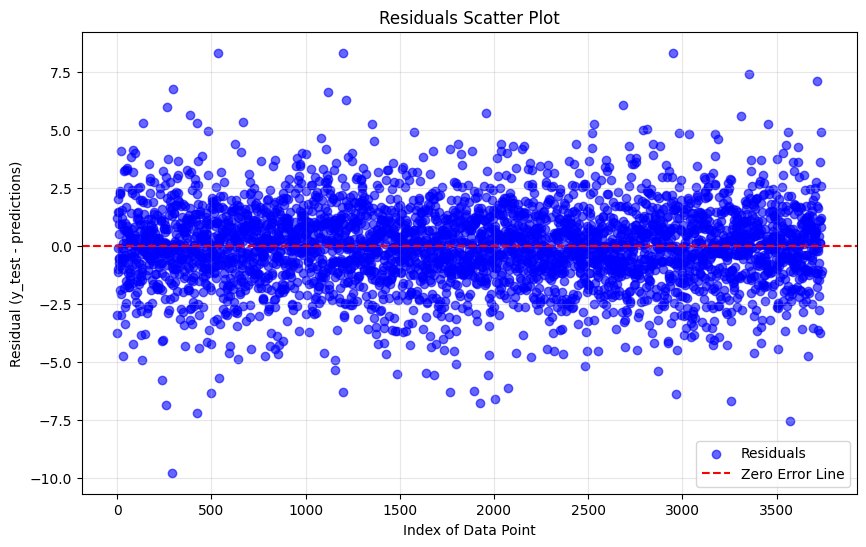

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.6, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('Residual (y_test - predictions)')
plt.title('Residuals Scatter Plot')
plt.legend()
plt.grid(alpha=0.3)

plt.show()


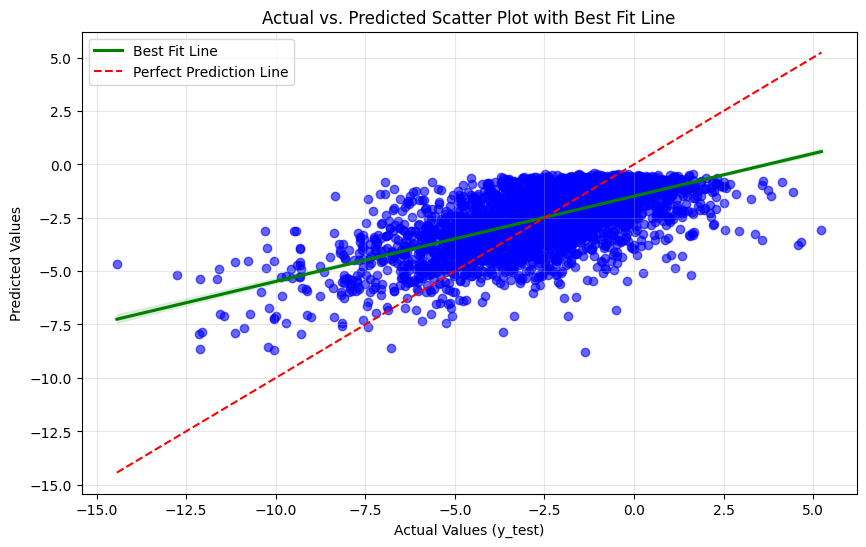

In [48]:
import seaborn as sns

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha': 0.6, 'label': 'Predicted vs. Actual'}, color='blue', line_kws={'color': 'green', 'label': 'Best Fit Line'})

# Add perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction Line')

# Labels and title
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Scatter Plot with Best Fit Line')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

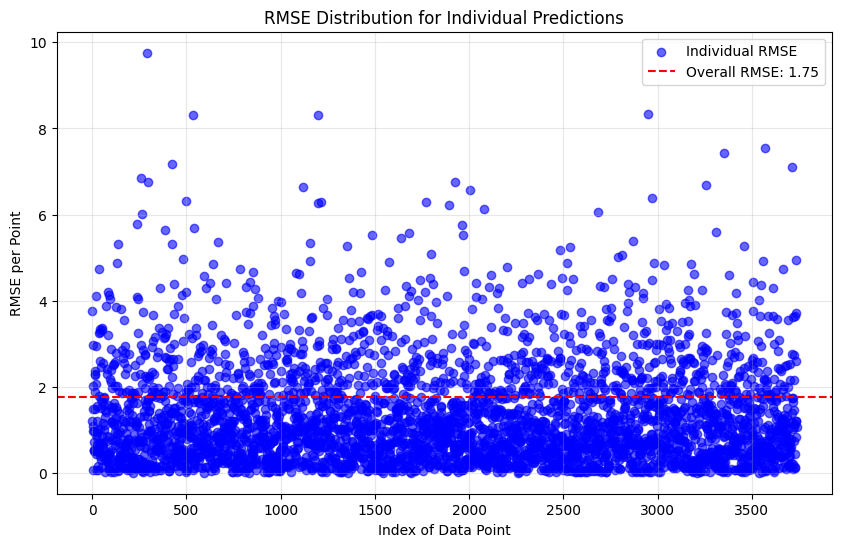

In [49]:
# Calculate individual RMSE values (absolute errors)
individual_rmse = np.sqrt((y_test - predictions) ** 2)

# Scatter plot of individual RMSE values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(individual_rmse)), individual_rmse, alpha=0.6, color='blue', label='Individual RMSE')
plt.axhline(y=rmse, color='red', linestyle='--', label=f'Overall RMSE: {rmse:.2f}')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('RMSE per Point')
plt.title('RMSE Distribution for Individual Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.show()
